<a href="https://colab.research.google.com/github/namozhdehi/Pneumonia-/blob/main/03_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Exploratory Data Analysis<a id='3_Exploratory'></a>

## 3.1 Contents<a id='3.1_Contents'></a>

## 3.1 Contents<a id='3.1_Contents'></a>
* [3 Data wrangling](#3_Data_wrangling)
  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Imports](#3.3_Imports)
  * [3.4 Data Extraction](#3.4_Extraction)
  * [3.10 Save the DataFrame](#3.10_Save)
  * [3.12 Summary](#3.12_Summary)

## 3.2 Introduction<a id='3.2_Introduction'></a>

This notebook performs Exploratory Data Analysis (EDA) on a chest X-ray dataset for pneumonia detection. The key objectives are to explore the structure and content of the dataset, visualize important features such as class distribution, image size, and pixel intensity, and ensure data quality by identifying missing values and duplicates. Additionally, we apply data augmentation techniques to enhance the dataset, making it more robust for training deep learning models. The insights gathered from this EDA will guide the next steps in building a model for pneumonia detection using chest X-rays.

## 3.2 Imports<a id='3.2_Imports'></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
import os

import warnings
warnings.filterwarnings('ignore')

## 3.3 Setup Kaggle API<a id='3.3_Kaggle'></a>

This code sets up the Kaggle API credentials to download the "chest-xray-pneumonia" dataset from Kaggle, unzips the dataset into a folder named "Data/chest_xray," and checks if the directory exists, raising an error if it doesn't.

In [2]:
# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/kaggle.json"  # Update this path

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded file
import zipfile

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')  # Extract to a folder named 'chest_xray'

# Define the data directory where the dataset is extracted
data_dir = 'Data/chest_xray'

# Check if data_dir exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The dataset directory '{data_dir}' does not exist. Please check the path.")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


## 3.4 Load the Data<a id='3.4_Load'></a>

In [3]:
# Load Data from CSV files and concatenate chunks into full DataFrames
train_df = pd.concat(pd.read_csv('chest_xray_image_data_train.csv', chunksize=1000))
val_df = pd.concat(pd.read_csv('chest_xray_image_data_val.csv', chunksize=1000))
test_df = pd.concat(pd.read_csv('chest_xray_image_data_test.csv', chunksize=1000))

## 3.5 Explore Data<a id='3.5_Explore'></a>

In [4]:
# Checking Basic Data Information
def check_basic_info(df, dataset_name):
    print(f"\n{dataset_name} Dataset Info:")
    df_info = df.info(memory_usage='deep')  # Use this without print to avoid printing "None"
    print(df_info)
    print(f"\n{dataset_name} Dataset Head:")
    print(df.head(), "\n", "-" * 50)

check_basic_info(train_df, "Training")
check_basic_info(val_df, "Validation")
check_basic_info(test_df, "Test")


Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_path    4172 non-null   object
 1   label         4172 non-null   int64 
 2   dataset_type  4172 non-null   object
dtypes: int64(1), object(2)
memory usage: 749.5 KB
None

Training Dataset Head:
                                          image_path  label dataset_type
0     Data/chest_xray/train/NORMAL/IM-0273-0001.jpeg      0        train
1  Data/chest_xray/train/NORMAL/NORMAL2-IM-1306-0...      0        train
2  Data/chest_xray/train/PNEUMONIA/person963_viru...      1        train
3  Data/chest_xray/train/PNEUMONIA/person1016_bac...      1        train
4  Data/chest_xray/train/PNEUMONIA/person1604_vir...      1        train 
 --------------------------------------------------

Validation Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries,

The training dataset contains 4,172 entries, with each row representing an image path, label (0 for "Normal" and 1 for "Pneumonia"), and the dataset type. The validation dataset contains 1,044 entries, and the test dataset has 624 entries, both structured similarly to the training dataset. There are no missing values in any of the datasets, and the images are evenly categorized as either "train," "validation," or "test" based on their dataset type.

## 3.6 Check Missing Values<a id='3.6_Missing'></a>

In [5]:
# Checking for Missing Values
def check_missing_values(df, dataset_name):
    print(f"\nChecking missing values in {dataset_name}:")
    print(df.isnull().sum())

check_missing_values(train_df, "Training Set")
check_missing_values(val_df, "Validation Set")
check_missing_values(test_df, "Test Set")


Checking missing values in Training Set:
image_path      0
label           0
dataset_type    0
dtype: int64

Checking missing values in Validation Set:
image_path      0
label           0
dataset_type    0
dtype: int64

Checking missing values in Test Set:
image_path      0
label           0
dataset_type    0
dtype: int64


The results show that there are no missing values in the image_path, label, or dataset_type columns for the training, validation, or test datasets. This confirms that the datasets are complete and ready for further analysis without the need for handling missing data.

## 3.7 Duplicate Data<a id='3.7_Duplicate'></a>

In [6]:
# Function to check for duplicate images based on image file content
def check_duplicates(df):
    image_hashes = {}
    duplicates = []

    for img_path in df['image_path']:
        try:
            with Image.open(img_path) as img:
                img_hash = hash(img.tobytes())  # Hash the image content
                if img_hash in image_hashes:
                    duplicates.append((img_path, image_hashes[img_hash]))  # Save duplicate pairs
                image_hashes[img_hash] = img_path
        except FileNotFoundError:
            print(f"File not found: {img_path}")
        except UnidentifiedImageError:
            print(f"Corrupted image found: {img_path}")

    if duplicates:
        print(f"Found {len(duplicates)} duplicate images:")
        for dup1, dup2 in duplicates:
            print(f"Duplicate: {dup1} and {dup2}")
    else:
        print("No duplicate images found.")

# Check for duplicates in the training dataset
check_duplicates(train_df)


Found 16 duplicate images:
Duplicate: Data/chest_xray/train/PNEUMONIA/person264_bacteria_1231.jpeg and Data/chest_xray/train/PNEUMONIA/person264_bacteria_1230.jpeg
Duplicate: Data/chest_xray/train/NORMAL/NORMAL2-IM-0587-0001-0001.jpeg and Data/chest_xray/train/NORMAL/NORMAL2-IM-0587-0001-0002.jpeg
Duplicate: Data/chest_xray/train/PNEUMONIA/person162_virus_322.jpeg and Data/chest_xray/train/PNEUMONIA/person162_virus_321.jpeg
Duplicate: Data/chest_xray/train/PNEUMONIA/person266_bacteria_1237.jpeg and Data/chest_xray/train/PNEUMONIA/person266_bacteria_1238.jpeg
Duplicate: Data/chest_xray/train/PNEUMONIA/person1312_bacteria_3318.jpeg and Data/chest_xray/train/PNEUMONIA/person1312_bacteria_3317.jpeg
Duplicate: Data/chest_xray/train/PNEUMONIA/person1496_bacteria_3909.jpeg and Data/chest_xray/train/PNEUMONIA/person1496_bacteria_3910.jpeg
Duplicate: Data/chest_xray/train/PNEUMONIA/person834_bacteria_2747.jpeg and Data/chest_xray/train/PNEUMONIA/person834_bacteria_2748.jpeg
Duplicate: Data/ches


The results indicate that 16 duplicate images were found in the training dataset, with identical or nearly identical images stored under different file names. These duplicates occur across both "Normal" and "Pneumonia" categories and may need to be removed to prevent bias in the model training process. Handling these duplicates is crucial to ensure a more accurate and unbiased training outcome.

## 3.8 Data Visualization<a id='3.8_Visualization'></a>

### 3.8.1 Class Distribution Analysis<a id='3.8.1_Distribution'></a>

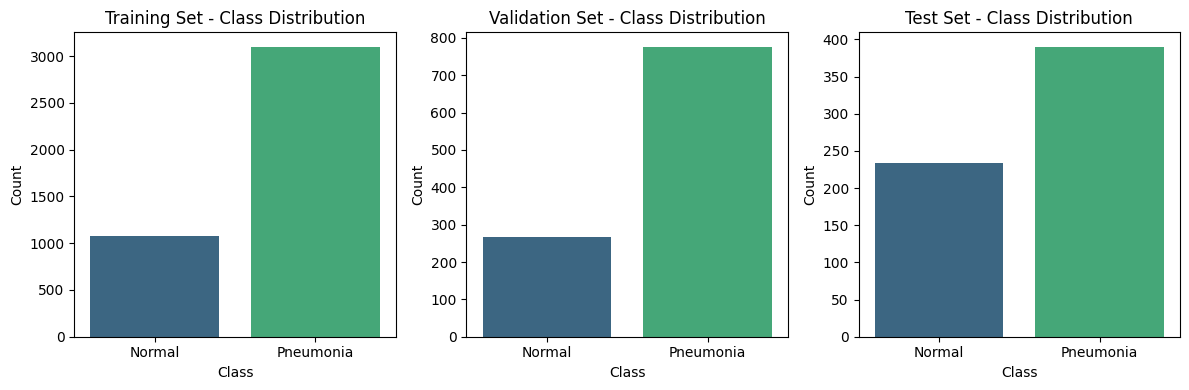

In [7]:
# Class Distribution Analysis
def plot_class_distribution_1x3(train_df, val_df, test_df):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create 1 row and 3 columns of subplots

    datasets = [(train_df, 'Training Set'), (val_df, 'Validation Set'), (test_df, 'Test Set')]

    for ax, (dataset, dataset_name) in zip(axes, datasets):
        sns.countplot(x=dataset['label'], palette='viridis', ax=ax)
        ax.set_title(f'{dataset_name} - Class Distribution')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Normal', 'Pneumonia'])

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function to plot class distribution for train, validation, and test sets
plot_class_distribution_1x3(train_df, val_df, test_df)

The class distribution plots for the training, validation, and test sets show a clear imbalance between the "Normal" and "Pneumonia" classes. In all three datasets, the "Pneumonia" class has significantly more samples compared to the "Normal" class. Specifically, in the training set, there are over 3,000 Pneumonia cases compared to around 1,000 Normal cases. This pattern is also evident in the validation and test sets, where Pneumonia cases outnumber Normal cases by a similar proportion. Addressing this class imbalance is important to ensure the model does not become biased toward predicting the majority class.

### 3.8.2 Visualizing Random Sample Images<a id='3.8.2_Sample'></a>

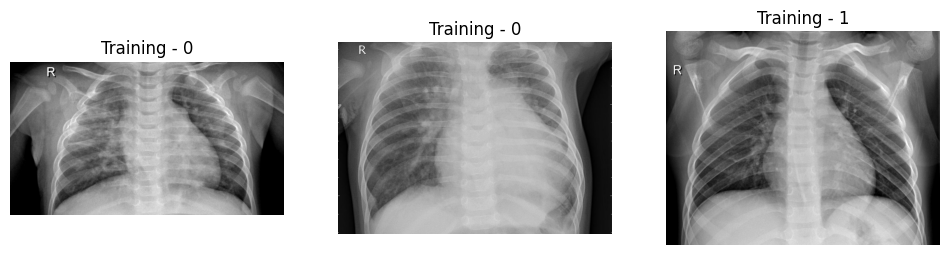

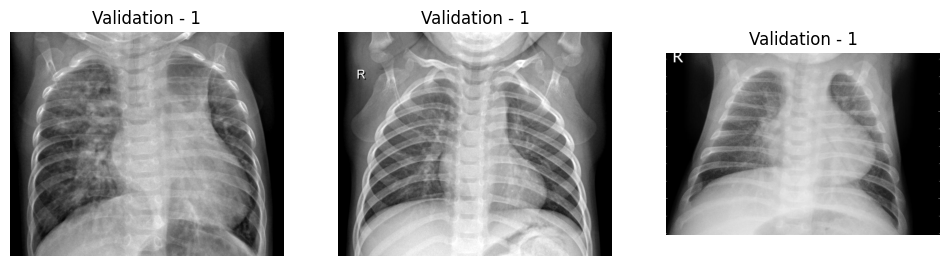

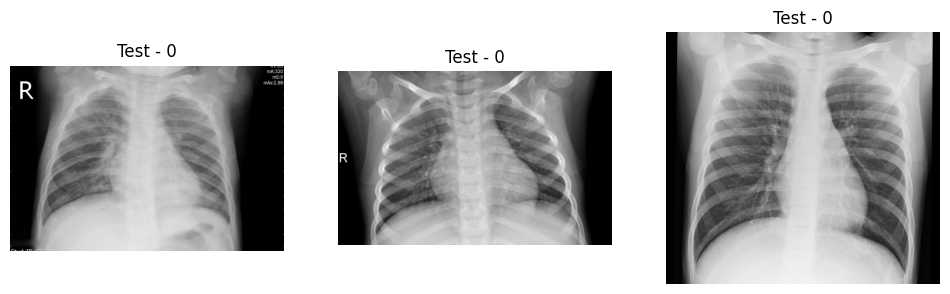

In [8]:
# Visualizing Random Sample Images
def visualize_sample_images(df, dataset_type, num_images=3):  # Reduce number of images to reduce memory usage
    sample_paths = df.sample(num_images)['image_path'].values
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{dataset_type} - {df['label'].values[i]}")
        axes[i].axis('off')

    plt.show()

# Visualize fewer images to avoid memory issues
visualize_sample_images(train_df, 'Training', 3)
visualize_sample_images(val_df, 'Validation', 3)
visualize_sample_images(test_df, 'Test', 3)

It displays random sample chest X-ray images from the training, validation, and test sets, labeled with their corresponding class (0 for "Normal" and 1 for "Pneumonia"). The X-rays show a variety of lung conditions, with clear differences between the "Normal" and "Pneumonia" cases. Images labeled "Pneumonia" exhibit cloudier or more opaque regions in the lungs, indicating infection, while the "Normal" cases generally show clearer lung structures. This visual exploration helps in understanding the data and the challenges the model may face in distinguishing between normal and pneumonia cases.

### 3.8.3 Image Size Distribution Analysis <a id='3.8.3_Image'></a>

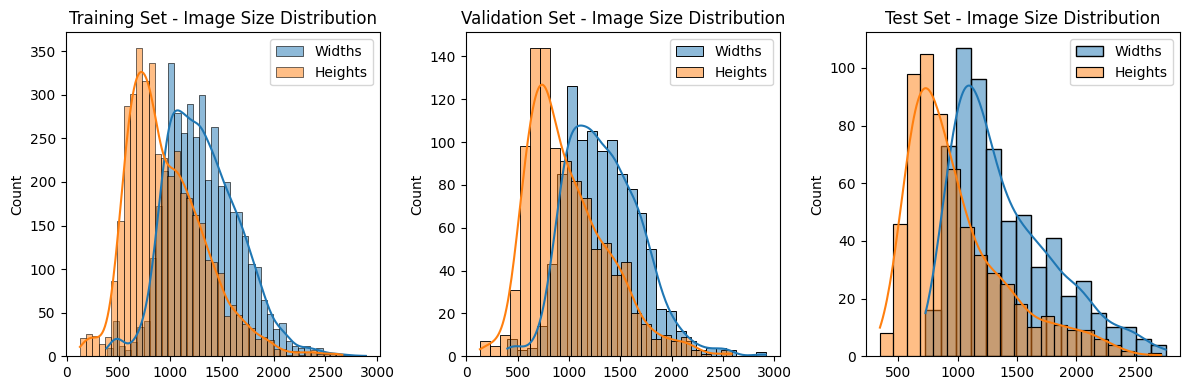

In [9]:
# Image Size Distribution Analysis (1x3 layout)
def analyze_image_size(train_df, val_df, test_df):
    datasets = [(train_df, "Training Set"), (val_df, "Validation Set"), (test_df, "Test Set")]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 layout for subplots

    for ax, (df, dataset_name) in zip(axes, datasets):
        sizes = []
        for img_path in df['image_path']:
            with Image.open(img_path) as img:
                sizes.append(img.size)

        widths, heights = zip(*sizes)

        sns.histplot(widths, label="Widths", kde=True, ax=ax, palette='viridis')
        sns.histplot(heights, label="Heights", kde=True, ax=ax, palette='viridis')

        ax.set_title(f"{dataset_name} - Image Size Distribution")
        ax.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function for the 1x3 plot
analyze_image_size(train_df, val_df, test_df)

It shows the distribution of image widths and heights for the training, validation, and test sets. Most images have widths between 500 and 1,500 pixels, and heights between 500 and 1,000 pixels. The pattern is similar across all three sets, with the training set having the most images. This suggests resizing the images would be important to ensure consistency during model training.

## 3.8.4 Pixel Intensity Distribution<a id='3.8.4_Pixel'></a>

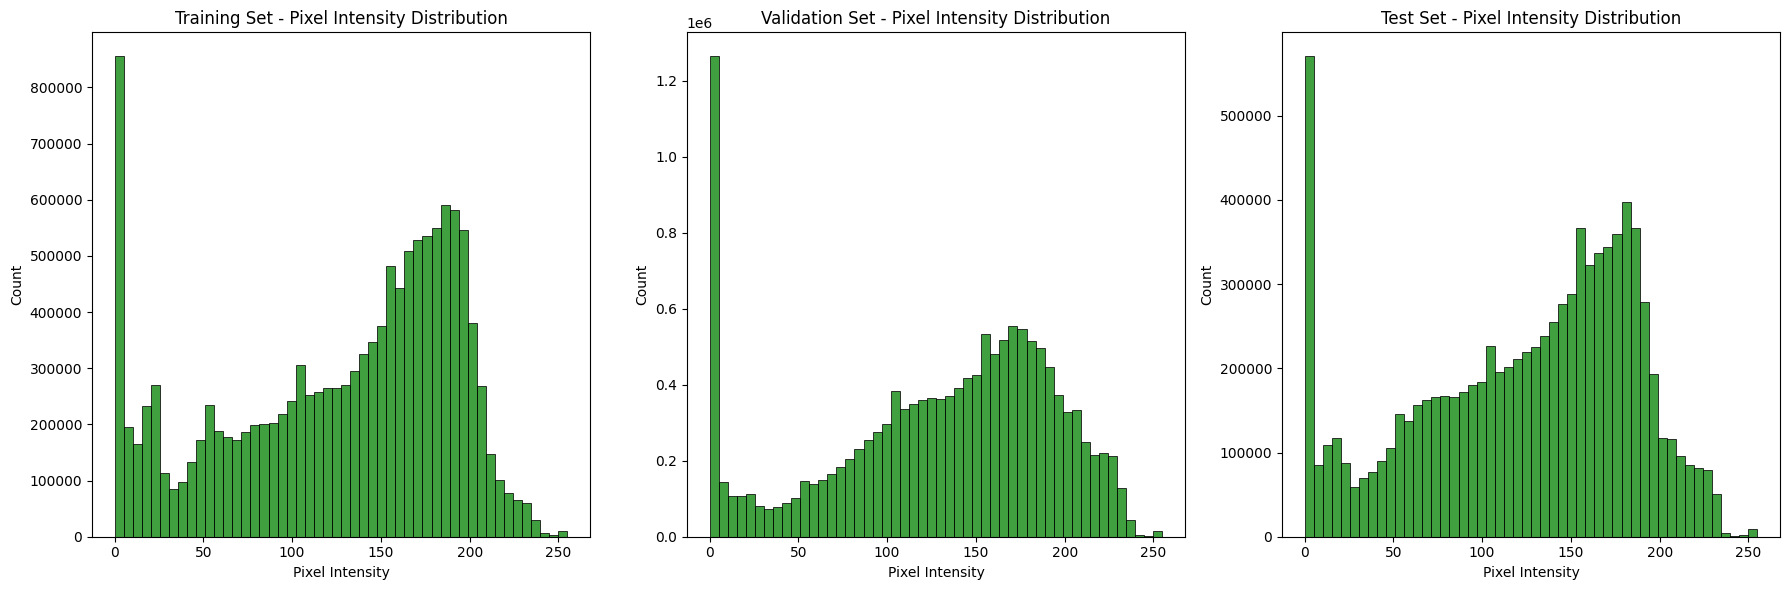

In [10]:
# Pixel Intensity Distribution for Training, Validation, and Test Sets (1x3 layout, optimized for memory)
def plot_pixel_intensity_distribution_optimized(train_df, val_df, test_df):
    datasets = [(train_df, "Training Set"), (val_df, "Validation Set"), (test_df, "Test Set")]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 layout for subplots

    for ax, (df, dataset_name) in zip(axes, datasets):
        all_pixels = []
        # Process an even smaller sample to avoid memory overload
        for img_path in df['image_path'].sample(10):  # Reduce the sample size to 10 images
            try:
                img = np.array(Image.open(img_path).convert('L'))  # Convert to grayscale
                all_pixels.extend(img.flatten())
            except (FileNotFoundError, UnidentifiedImageError):
                print(f"Error processing image: {img_path}")
                continue  # Skip corrupted or missing images

        # Plot pixel intensity distribution for a small sample
        sns.histplot(all_pixels, bins=50, ax=ax, kde=False, color='green', palette='viridis')
        ax.set_title(f"{dataset_name} - Pixel Intensity Distribution")
        ax.set_xlabel("Pixel Intensity")
        ax.set_ylabel("Count")

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function to plot pixel intensity distributions for train, val, and test sets
plot_pixel_intensity_distribution_optimized(train_df, val_df, test_df)

It shows the pixel intensity distribution of the dataset. Most pixels have low intensity values, with a large spike at intensity 0, indicating many completely black pixels. The rest of the distribution spreads across mid-range intensities, peaking around 150, and gradually declining toward the maximum intensity of 255. This suggests that many images have dark regions, typical in medical imaging like X-rays, with varying brightness levels throughout the images.

## 3.8.5 Data Augmentation<a id='3.8.5_Augmentation'></a>

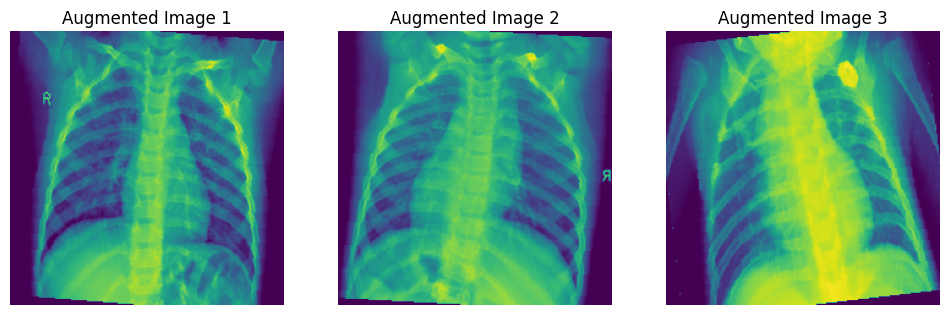

In [11]:
# Define Data Augmentation
import torchvision.transforms as transforms

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

# Limit to a smaller number of images to avoid memory overload
def visualize_augmented_images(df, transform, num_images=3):  # Reduced number of images to save memory
    sample_paths = df.sample(num_images)['image_path'].values
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        img_transformed = transform(img)
        img_transformed = np.transpose(img_transformed.numpy(), (1, 2, 0))  # Convert tensor to numpy array for plotting
        axes[i].imshow(img_transformed)
        axes[i].set_title(f'Augmented Image {i+1}')
        axes[i].axis('off')

    plt.show()

# Visualize augmentations
visualize_augmented_images(train_df, augmentation_transform, 3)

It shows three augmented X-ray images generated through data augmentation techniques such as random rotations and brightness adjustments. These augmentations help to create variations in the dataset, which can improve the model's ability to generalize by learning from slightly modified versions of the same data. In this case, the images retain the original structure but have been rotated and altered in brightness, simulating real-world variations in X-rays. This type of augmentation is beneficial in medical imaging to prevent overfitting and improve model robustness, especially when working with smaller datasets.

## 3.9 Save the DataFrame<a id='3.9_Save'></a>

In [12]:
# Save the processed data for use in the next step
train_df.to_csv('pneumonia_EDA_train.csv', index=False)
val_df.to_csv('pneumonia_EDA_val.csv', index=False)
test_df.to_csv('pneumonia_EDA_test.csv', index=False)

print("Data successfully saved for the next phase!")

Data successfully saved for the next phase!


## 3.10 Summary<a id='3.10_Summary'></a>

In this notebook, we conducted a comprehensive Exploratory Data Analysis (EDA) on a chest X-ray dataset for pneumonia detection. We explored the dataset's structure, checked for missing values, and identified duplicate images. The analysis revealed a significant class imbalance, with more pneumonia cases than normal cases, which will need to be addressed in model development. We also visualized random sample images, analyzed image size and pixel intensity distributions, and applied data augmentation techniques to improve model robustness. Finally, the processed data was saved for the next phase of model building.